# Árboles de Decisión

El algoritmo de árboles de decisión se cuentan entre los más transparentes. Si bien en por sí solos no son los algoritmos más poderosos, a partir de ellos pueden generarse algunos de los algoritmos más poderosos de aprendizaje automático, que veremos más adelante en el curso.

En este notebook, tomamos el primer contacto con estos modelos y mostramos algunas de sus características y limitaciones.

## Conceptos básicos

El algoritmo de **Arboles de Decisión** consiste, en gran parte, en dividir el espacio de datos a partir de decisiones binarias (con respuesta sí / no) sobre alguna de las características, como se muestra en la figura.

En cada región identificada, la predicción del modelo es muy sencilla (la moda de la distribución de clases o el promedio de los valores target, según si se trata de clasificación o regresión). Toda la sofisticación está en cómo encontrar la separación que mejor rendimiento tiene en términos de las predicciones que hará el modelo a partir de ella.

<img width=600 src="https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/images/decision_regions.png">


<!-- ![DT_decision_regions][def]

[def]: https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/images/decision_regions.png -->

Se llaman **árboles** de decisión porque la partición del espacio de las características se hace a partir de una sucesión de preguntas binarias, que pueden expresarse como un árbol.

<img width=500 src="https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/images/decision_regions.png">
<img width=500 src="https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/images/arbol.png">


Vamos a ver un ejemplo de clasificación para ir profundizando en el funcionamiento de este algoritmo. Aclaramos que puede usarse igualmente bien para **clasificaciones binarias** o **multi-clase**, y que además los árboles de decisión se pueden implementar para **problemas de regresión**.

**Ventajas**

* Fácil de entender e interpretar: Los árboles se pueden visualizar. White box.
* Requiere poca o nula preparación de los datos.
* Predicciones muy rápidas.

**Desventajas**
* Árboles demasiado complejos que no generalizan bien los datos.
* Inestables frente a pequeñas variaciones en los datos
* No son buenos para la extrapolación.
* Árbol óptimo es un problema NP-completo.
* Árboles sesgados si algunas clases dominan. Se recomienda equilibrar el conjunto de datos antes de ajustarlo con el árbol de decisión.

## Ejemplo de clasificación

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use('ggplot')

Utilizaremos el conjunto de datos Iris con sólo dos características, y vamos a entrenar un árbol de decisión para clasificar los datos según la especie de la flor.

In [ ]:
from sklearn import datasets

iris=datasets.load_iris()

# Nos quedamos con los dos primeros features
datos = iris.data[:, 2:]
etiquetas = iris.target

# Sacamos los nombres
# labelx, labely = iris.feature_names[2:]
labelx, labely = ['Largo del pétalo (cm)', 'Ancho del pétalo (cm)']


In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(datos, etiquetas)

DecisionTreeClassifier(max_depth=2, random_state=42)

Text(0, 0.5, 'Ancho del pétalo (cm)')

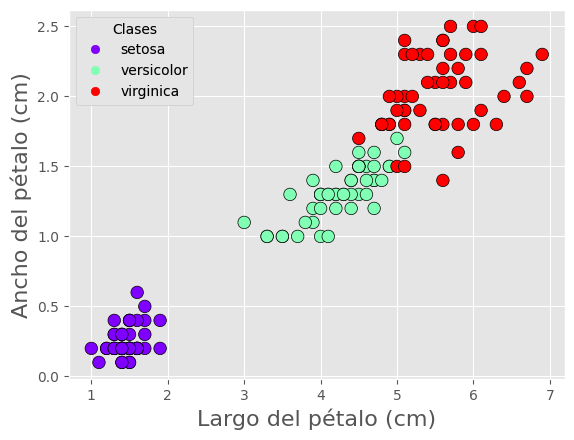

In [ ]:
# Graficamos
fig = plt.figure()#figsize=(12, 8))
ax = fig.add_subplot(111)
sct = ax.scatter(datos[:,0], datos[:, 1], c=etiquetas, edgecolors='k', s=9**2,
                  cmap=plt.cm.rainbow)

legend1 = ax.legend(sct.legend_elements()[0], iris.target_names,
                    loc="upper left", title="Clases")
ax.add_artist(legend1)

plt.xlabel(labelx, fontsize=16)
plt.ylabel(labely, fontsize=16)


Ahora, vamos a importar un `DecisionTreeClassifier` de `sklearn` (esto implementa una versión optimizada del algoritmo CART, incluyendo algunas características adicionales, pero restringido a sólo variables numéricas).

Podemos visualizar el árbol de decisión resultante utilizando el método `plot_tree` de la biblioteca `sklearn.tree`.

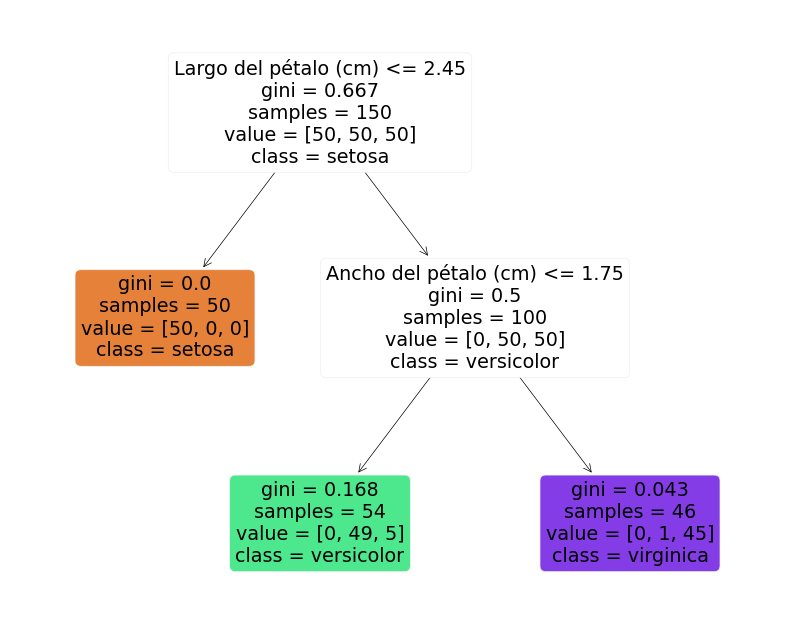

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 8))

plot_tree(tree_clf,
        #   feature_names=iris.feature_names[2:],
          feature_names=[labelx, labely],
          class_names=iris.target_names,
          rounded=True,
          filled=True)
plt.show()

Veamos un gráfico al lado del otro e intentemos entender qué está pasando y qué significa cada valor en el gráfico del árbol.

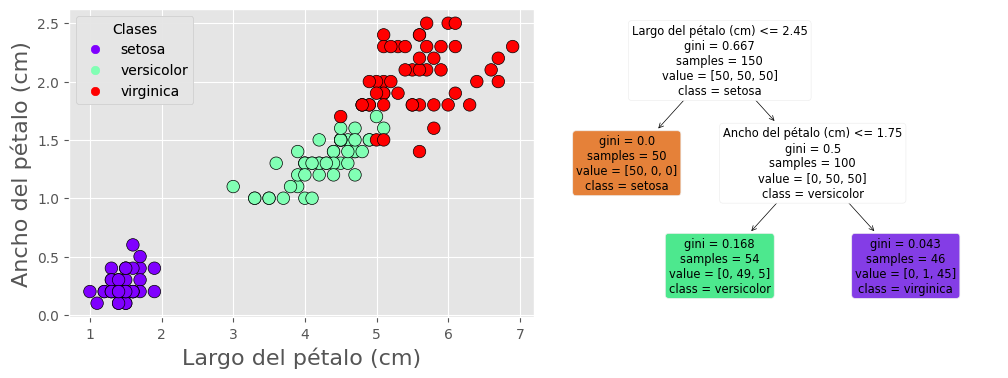

In [ ]:
# Graficamos
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.subplots_adjust(wspace=0)

sct = ax.scatter(datos[:,0], datos[:, 1], c=etiquetas, edgecolors='k', s=9**2,
                  cmap=plt.cm.rainbow)

legend1 = ax.legend(sct.legend_elements()[0], iris.target_names,
                    loc="upper left", title="Clases")
ax.add_artist(legend1)

ax.set_xlabel(labelx, fontsize=16)
ax.set_ylabel(labely, fontsize=16)

trplot = plot_tree(tree_clf,
          feature_names=[labelx, labely],
          class_names=iris.target_names,
          rounded=True,
          filled=True,
          ax=ax2)

Como es de esperar, una vez que el árbol está entrenado (¡todavía no dijimos cómo se hace!) podemos usar los métodos típicos `predict` y `predict_proba` para predecir la clase de un dato nuevo, no observado.

El método `predict_proba` devuelve un número que es la fracción de puntos correctamente clasificados del conjunto de entrenamiento en la hoja correspondiente:
$$p_k = \frac{N_k}{ N_{total}}\;\;,$$

con $$k = \{\text{setosa}, \text{versicolor}, \text{virginica}\}$$

In [ ]:
# Ejemplo
data_points = [
    [4, 1.5],
]

y = tree_clf.predict(data_points)
print('Predicción: {} ({})'.format(*y, *iris.target_names[y]))
print('Probabilidades', *tree_clf.predict_proba(data_points).round(4))

Predicción: 1 (versicolor)
Probabilidades [0.     0.9074 0.0926]


Vemos que, de hecho, los números corresponden a las fracciones observadas en la hoja correspondiente del árbol.

### *Algoritmo CART

Ahora que entendimos la estructura del árbol, nos concentramos en estudiar cómo se crea esa estructura. El algoritmo más común se llama CART (Classification and Regresión Trees). En cada bifurcación CART elige el *feature* y el valor que produce la máxima reducción de alguna función de costo; en el caso de la clasificación, se trata de un medición basada en alguna de las  métricas que se definen a continuación. Todas ellas disminuyen cuando los nodos terminales de los árboles (las hojas) tienen menor mezcla de clases.

1. **Índice de Gini**. En cada nodo, podemos calcular este índice, a partir de la fracción de muestras de cada clase, $p_k$, con $k = \{\text{setosa}, \text{versicolor}, \text{virginica}\}$. Para calcular el índice Gini, se suma $p_k (1 - p_k)$ para todas las clases:

$$
\sum_{k=1}^K p_k (1 - p_k)\;\;.
$$

Por ejemplo, calculemos el índice de Gini para el nodo raíz, que tiene 50 mustras de cada clase. Es decir, $p_k = 50/150 = 1/3$ para todas las clases. Entonces, tenemos $1/3 \cdot(1 - 1/3) = 2/9$, para cada clase. El total para ese nodo, será $6/9 \sim 0.667$, que es lo que figura en el gráfico.

Si queremos calcular el índice de Gini después del primer *split*, entonces, tenemos que calcular el índice para cada nuevo nodo y sumarlos, ponderados por la cantidad de muestras que tiene cada uno.

En el nodo de la izquierda, tenemos solo muestra de Setosa. En ese caso el índice de Gini es cero. En el nodo de la derecha, tenemos 50 de Versicolor y 50 de Virginica: $50/100 \cdot (1 - 50/100) = 1/4$ para cada clase. Por lo tanto, tenemos índice de Gini del nodo: $0.5$. El árbol después del primer corte tiene

$$
\frac{50}{150} \text{Gini izquierda} + \frac{100}{150} \text{Gini derecha} = 0 + \frac{2}{3} \frac{1}{2} = \frac{1}{3}\;\;,
$$
que es menor que el $2/3$ del nodo raíz. Esta división es la que mayor **reducción de Gini** presenta.


2. **Entropía**. Se usa indistintamente, y también cumple con la propiedad de que en un nodo que contiene muestras de una sola clase, el valor de la entropía es cero.

$$
- \sum_{k=1}^K p_k \log p_k\;\;.
$$

En los **árboles de decisión** los cortes se realizan según *features* individuales (es decir, son cortes perpendiculares a algún eje), de manera que se minimice la "impureza" del árbol resultante. El algoritmo CART es *codicioso* (*greedy*), en el sentido de que elije el mejor corte (es decir, el mejor *feature*) en ese momento, sin miramientos hacia los futuros cortes. Existe la posibilidad de que un corte sub-óptimo en un nivel conduzca a un mejor resultado final, pero encontrar el árbol óptimo es un problema computacional muy complejo.

Por lo tanto, nos contentamos con este algoritmo **greedy**.


### Visualizando las regiones de decisión

Para graficar las regiones de decisión, generamos una cuadrícula de puntos y obtenemos la predicción del modelo sobre ella.

Luego utilizamos el método `contourf` para pintar la región. Todo esto se implementa en esta función de A. Gèron:

<Figure size 1200x800 with 0 Axes>

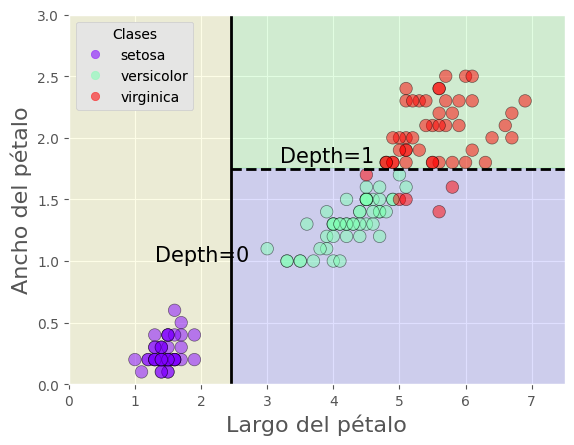

In [ ]:
# Función adaptada de A. Gèron
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, t, axes=[0, 7.5, 0, 3], is_iris=True,
                           legend=False, plot_training=True, ngridpoints=200,
                           alpha=1.0, ax=None):

    # Prepara los arreglos para colorear
    x1s = np.linspace(axes[0], axes[1], ngridpoints)
    x2s = np.linspace(axes[2], axes[3], ngridpoints)

    # los convierte en una grilla
    x1, x2 = np.meshgrid(x1s, x2s)

    # Calcula las predicciones sobre la grilla
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    if ax is None:
        ax = plt.figure().add_subplot(111)

    # Grafica con colores esa grilla
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    if not is_iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        sct = ax.scatter(X[:,0], X[:, 1], c=t, edgecolors='k', s=9**2,
                  cmap=plt.cm.rainbow, alpha=alpha)

        # plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        # plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        # plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        # plt.axis(axes)
    if is_iris:
        legend1 = ax.legend(sct.legend_elements()[0], iris.target_names,
                            loc="upper left", title="Clases")
        ax.add_artist(legend1)

        ax.set_xlabel("Largo del pétalo", fontsize=16)
        ax.set_ylabel("Ancho del pétalo", fontsize=16)
    else:
        ax.set_xlabel(r"$x_1$", fontsize=18)
        ax.set_ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        ax.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(12, 8))
plot_decision_boundary(tree_clf, datos, etiquetas, alpha=0.5)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.30, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=15)

plt.show()

### Importancias de las características

Comparando las reducciones de impurezas dadas por el mejor corte de cada característica podemos estimar la _importancias de las características_ (*feature importances*), a la que se accede a través del atributo `.feature_importances_`.

In [ ]:
tree_clf.feature_importances_

array([0.56199095, 0.43800905])

<BarContainer object of 2 artists>

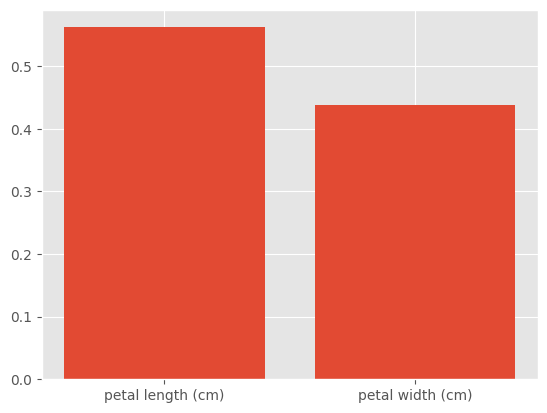

In [ ]:
plt.bar(iris.feature_names[2:], tree_clf.feature_importances_)

En este caso, vemos que ambas características paracen tener una importancia similar, con una ligera ventaja para el largo del pétalo.

## Sobreajuste

Por defecto, un `DecisionTreeClassifier` no está regularizado, y el árbol crecerá hasta alcanzar una separación de clases perfecta.

En el ejercicio anterior, fijamos `max_depth=2`, lo que limita el árbol a tener, a lo sumo, dos niveles de decisión. Veamos qué ocurre si sacamos esto.

In [ ]:
tree_clf_noregu = DecisionTreeClassifier()
tree_clf_noregu.fit(datos, etiquetas)

DecisionTreeClassifier()

Grafiquemos el árbol resultante.

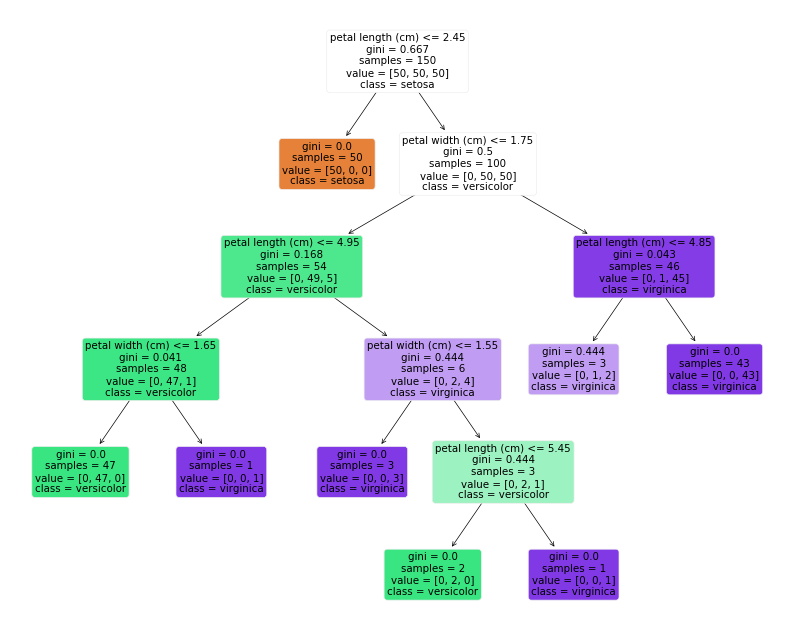

In [ ]:

plt.figure(figsize=(10, 8))

plot_tree(tree_clf_noregu,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names,
          rounded=True,
          filled=True)
plt.show()

<BarContainer object of 2 artists>

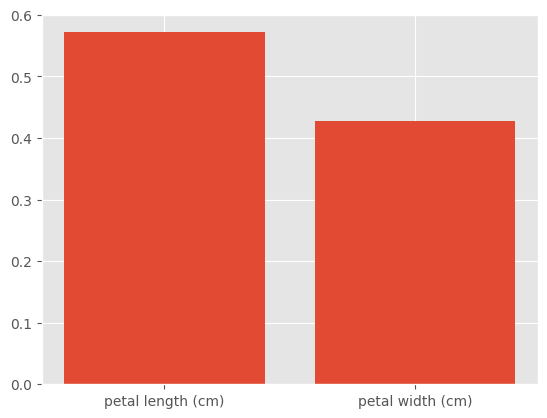

In [ ]:
plt.bar(iris.feature_names[2:], tree_clf_noregu.feature_importances_)

Podemos averiguar cuántos cortes hizo, cuántos nodos hoja tiene y otras cosas.

In [ ]:
print('Profundidad del árbol:', tree_clf_noregu.get_depth())
print('Número de nodos terminales (hoja): ', tree_clf_noregu.get_n_leaves())

Profundidad del árbol: 5
Número de nodos terminales (hoja):  8


También podemos ver cómo cabmian las regiones de decisión

<Figure size 1200x800 with 0 Axes>

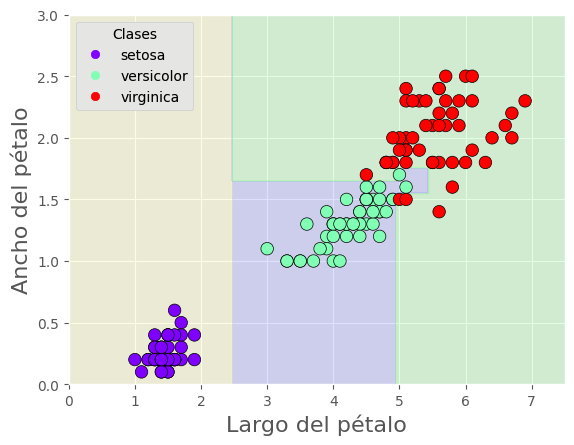

In [ ]:
plt.figure(figsize=(12, 8))
plot_decision_boundary(tree_clf_noregu, datos, etiquetas)
plt.show()

La elección del mejor valor para este **hiperparámetro** debe hacerse con validación cruzada.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Creo la búsqueda
treecv = GridSearchCV(estimator=tree_clf_noregu,
                      param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]},
                      cv=5,
                      scoring='roc_auc_ovr')

# Ajusto
treecv.fit(datos, etiquetas)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]},
             scoring='roc_auc_ovr')

Como solíamos hacer, podemos acceder a un diccionario con los valores de los mejores parámetros, y también al mejor árbol, reentrenado sobre todo el conjunto de entrenamiento.

{'max_depth': 3}


<Figure size 1200x800 with 0 Axes>

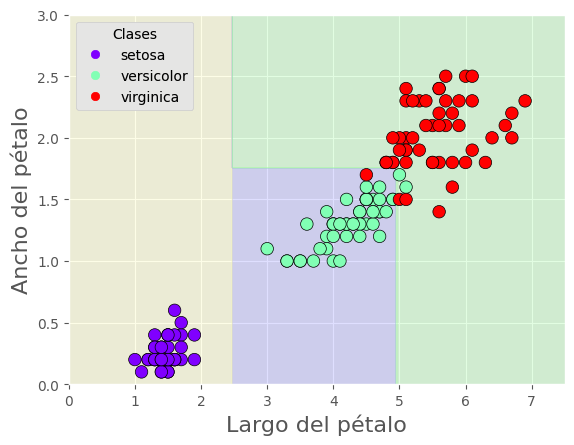

In [ ]:
print(treecv.best_params_)
mejor_arbol = treecv.best_estimator_

plt.figure(figsize=(12, 8))
plot_decision_boundary(mejor_arbol, datos, etiquetas)
plt.show()

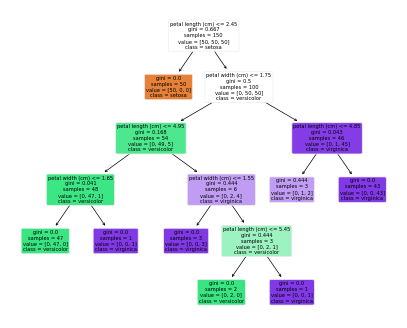

In [ ]:
plt.figure(figsize=(5, 4))

plot_tree(mejor_arbol,
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names,
          rounded=True,
          filled=True)
plt.show()

## Hiperparámetros

Además de `max_depth`, los árboles de decisión tienen un gran cantidad de hiperparámetros que se pueden ajustar para mejorar la generalización.

* `max_depth`. La profundidad máxima del árbol.
* `min_samples_split`. El número mínimo de muestras necesarias para dividir un nodo interno. Si el número de muestras es menor que este parámetro, el nodo interno se convierte en una hoja.
* `min_samples_leaf`. Número mínimo de muestras (o fracción de muestra si se proporciona un punto flotante) que debe haber en un nodo hoja. Un punto de división en cualquier profundidad sólo se considerará si deja al menos ``min_samples_leaf`` muestras de entrenamiento en cada una de las ramas izquierda y derecha.
* `max_leaf_nodes`. Una vez crecido el árbol, sólo se conservan los mejores `max_leaf_nodes` nodos hoja. Los mejores nodos se definen a partir de la reducción relativa de la impureza.    
* `min_impurity_decrease`. Un nodo será dividido solo si esta división induce una disminución de la impureza mayor o igual a este valor.

El valor óptimo de estos parámetros debe encontrarse mediante.... (todos a una) **validación cruzada**.

In [ ]:
DecisionTreeClassifier?

In [ ]:
df = pd.DataFrame(datos)
df.duplicated?

## *Cortes cartesianos

En principio, un árbol puede aproximar cualquier forma que tenga la frontera de decisión, pero como las divisiones binarias se realizan sobre una sola característica a la vez, la complejidad de la resultante es muy suceptible a las orientaciones de las características.

Pongamos un ejemplo ilustrativo:

In [ ]:
# Primera clase: 50 puntos que siguen una distribución binormal
size1 = 50
mu1 = [0, 0]
cov1 = [[1, 0],[0, 1]]

# Segunda clase: 50 puntos que siguen una distribución binormal
size2 = 50
mu2 = [4, 0]
cov2 = [[1, 0],[0, 1]]

# Fijamos la semilla
np.random.seed(42)

# Muestreamos las clases
xc1 = np.random.multivariate_normal(mean=mu1, cov=cov1, size=size1).T
xc2 = np.random.multivariate_normal(mean=mu2, cov=cov2, size=size2).T

# Les ponemos targets: 1 and 0
tc1 = np.ones((1, xc1.shape[1]))
tc2 = np.zeros((1, xc2.shape[1]))
# tc2 = -np.ones((1, xc2.shape[1]))

# Y los juntamos en un único vector
x = np.hstack([xc1, xc2]).T
t = np.hstack([tc1, tc2]).ravel()

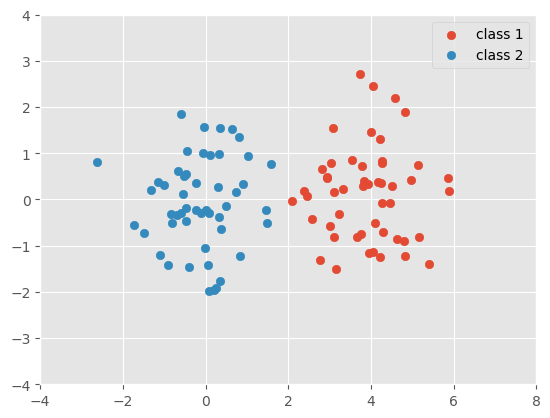

In [ ]:
# Hacemos una gráfica
plt.scatter(x[t==0][:,0], x[t==0][:,1], label='class 1')
plt.scatter(x[t==1][:,0], x[t==1][:,1], label='class 2')

plt.xlim(-4,8)
plt.ylim(-4,4)

plt.legend()
plt.show()

Este conjunto de datos es linealmente separable, y los clusters se separan paralelamente a una de las características. Vamos a entrenar un DecisionTreeClassifier en este conjunto:

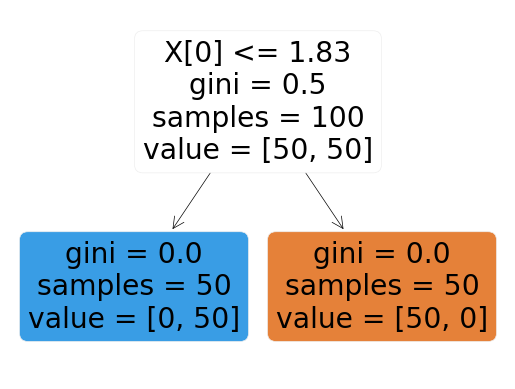

In [ ]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(x,t)

plot_tree(tree_clf, filled=True, rounded=True)
plt.show()

El árbol resultante es extremadamente simple, así como la frontera de decisión:

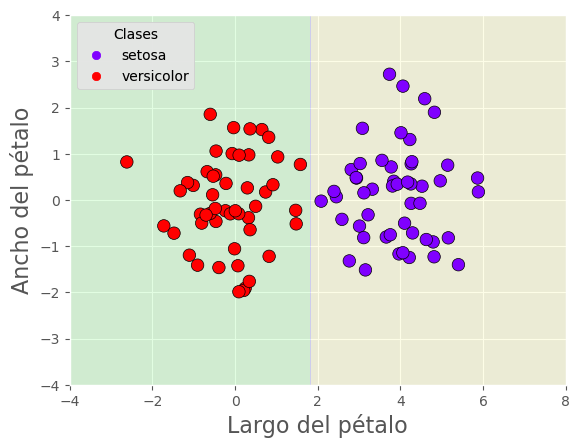

In [ ]:
plot_decision_boundary(tree_clf,x,t, axes=[-4, 8, -4, 4])

Ahora rotemos los puntos 45 grados.

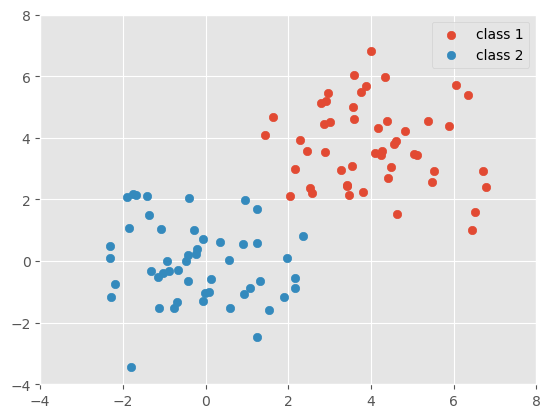

In [ ]:
x_rotated = np.zeros(x.shape)
x_rotated[:,0] = x[:,0]+x[:,1]
x_rotated[:,1] = x[:,0]-x[:,1]

plt.scatter(x_rotated[t==0][:,0], x_rotated[t==0][:,1], label='class 1')
plt.scatter(x_rotated[t==1][:,0], x_rotated[t==1][:,1], label='class 2')

plt.xlim(-4,8)
plt.ylim(-4,8)

plt.legend()
plt.show()

El conjunto de datos sigue siendo linealmente separable, pero el límite de decisión ya no está alineado con nuestras características.

Veamos el árbol de decisión resultante:

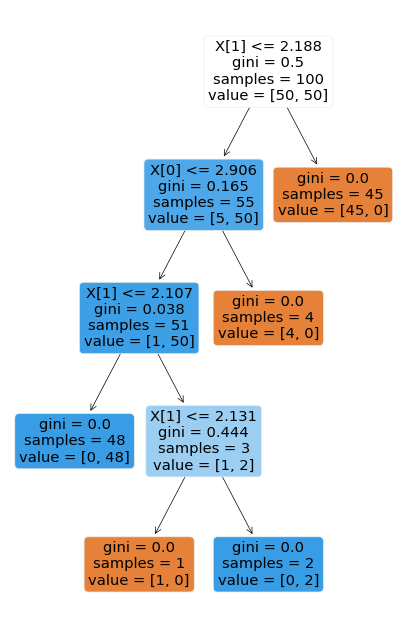

In [ ]:
rotated_tree_clf = DecisionTreeClassifier()
rotated_tree_clf.fit(x_rotated,t)

plt.figure(figsize=(5,8))
plot_tree(rotated_tree_clf, filled=True, rounded=True)
plt.show()

Vemos que es mucho más complejo, pero es lo que se necesita para aproximar la nueva frontera de decisión.

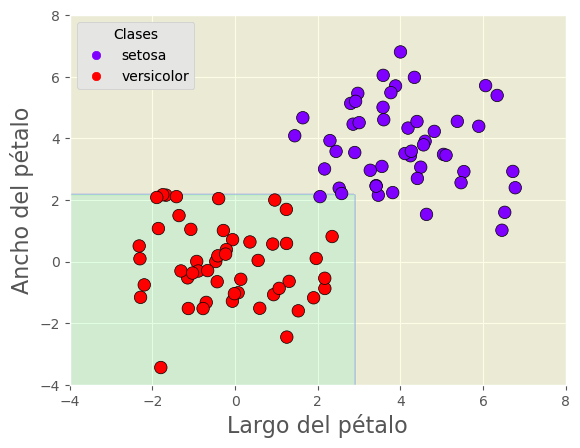

In [ ]:
plot_decision_boundary(rotated_tree_clf,x_rotated,t, axes=[-4, 8, -4, 8])

**Como podemos ver, es mucho más difícil para el Árbol de Decisión aprender regiones que no están alineadas con las características.**

---

## Regresión

Los árboles de decisión también pueden utilizarse para tareas de regresión. La idea es la misma:

* Dividir el espacio de características en regiones definidas por umbrales en las variables.
* Las predicciones se calculan como la media de los objetivos en ese nodo.
* Las divisiones se eligen para maximizar la disminución de la función de pérdida MSE.

Vamos a mostrar con un ejemplo de la documentación de `sklearn`

Text(0, 0.5, 'target')

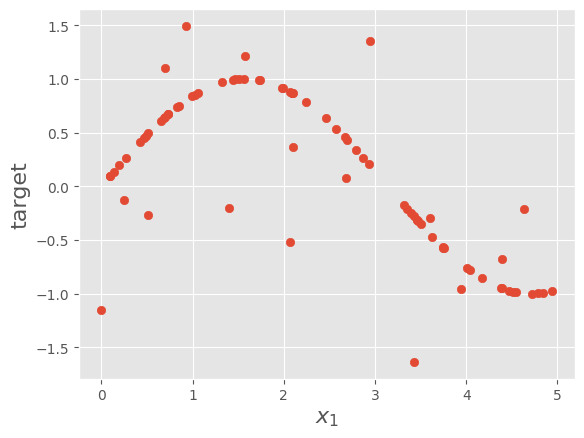

In [ ]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

plt.scatter(X,y)
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('target', fontsize=16)

Ajustemos dos árboles de decisión de profundidad máxima diferente

In [ ]:
DecisionTreeRegressor?

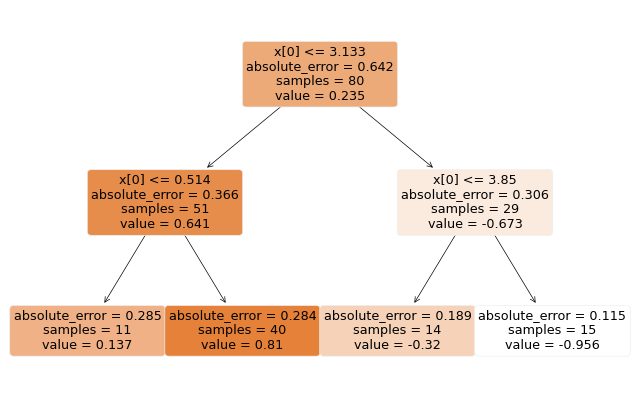

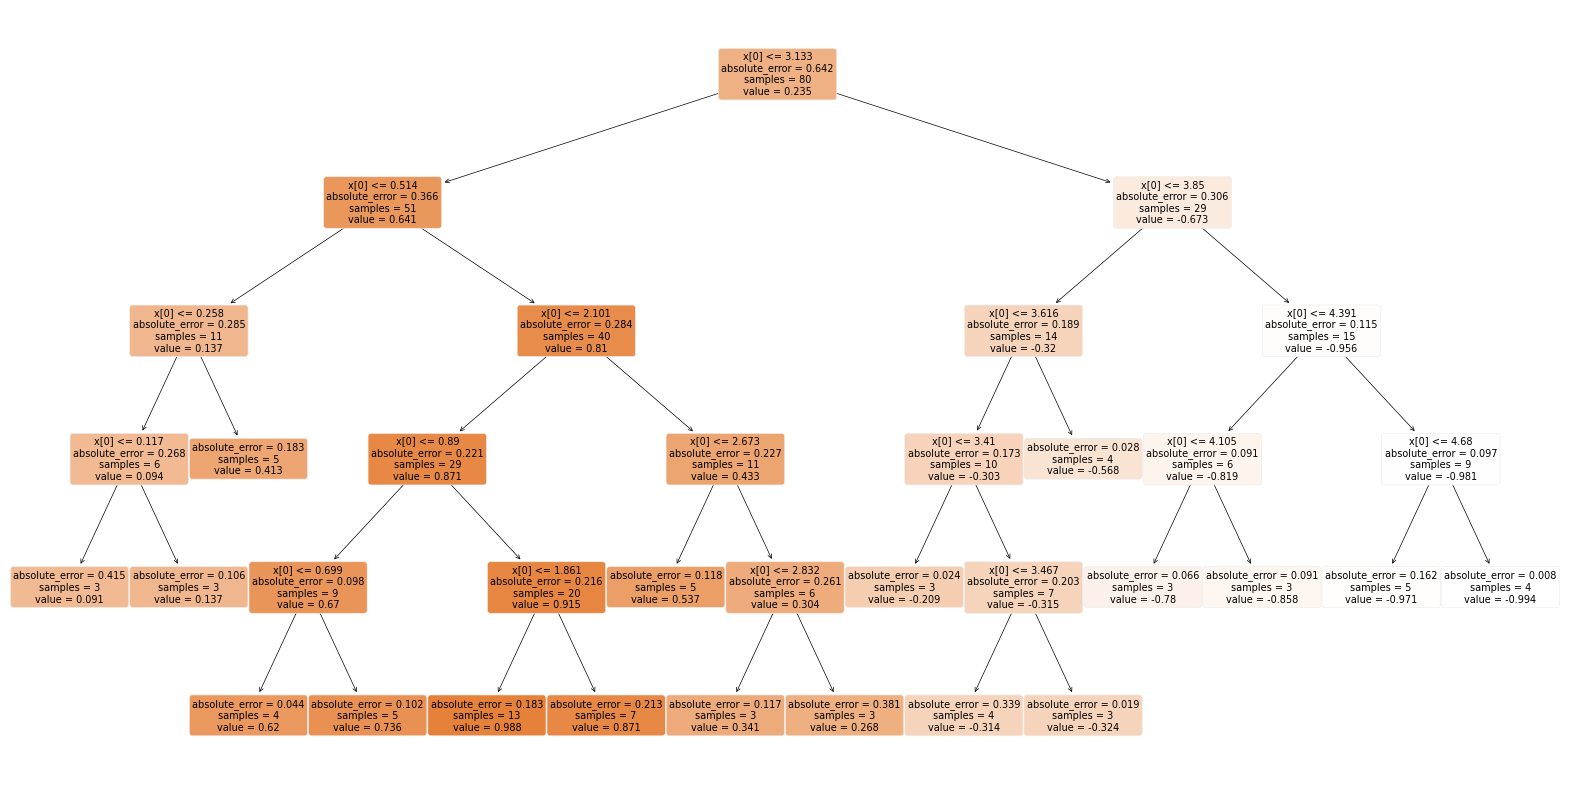

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
tree_reg_1 = DecisionTreeRegressor(max_depth=2, min_samples_leaf=3, criterion="absolute_error")
tree_reg_2 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=3, criterion="absolute_error")

tree_reg_1.fit(X,y)
tree_reg_2.fit(X,y)

plt.figure(figsize=(8,5))
plot_tree(tree_reg_1, filled=True, rounded=True)
plt.show()
plt.figure(figsize=(20,10))
plot_tree(tree_reg_2, filled=True, rounded=True)
plt.show()

¡Qué complejidad del árbol más profundo! En cada nodo, el atributo `value` nos da la predicción cada nodo.

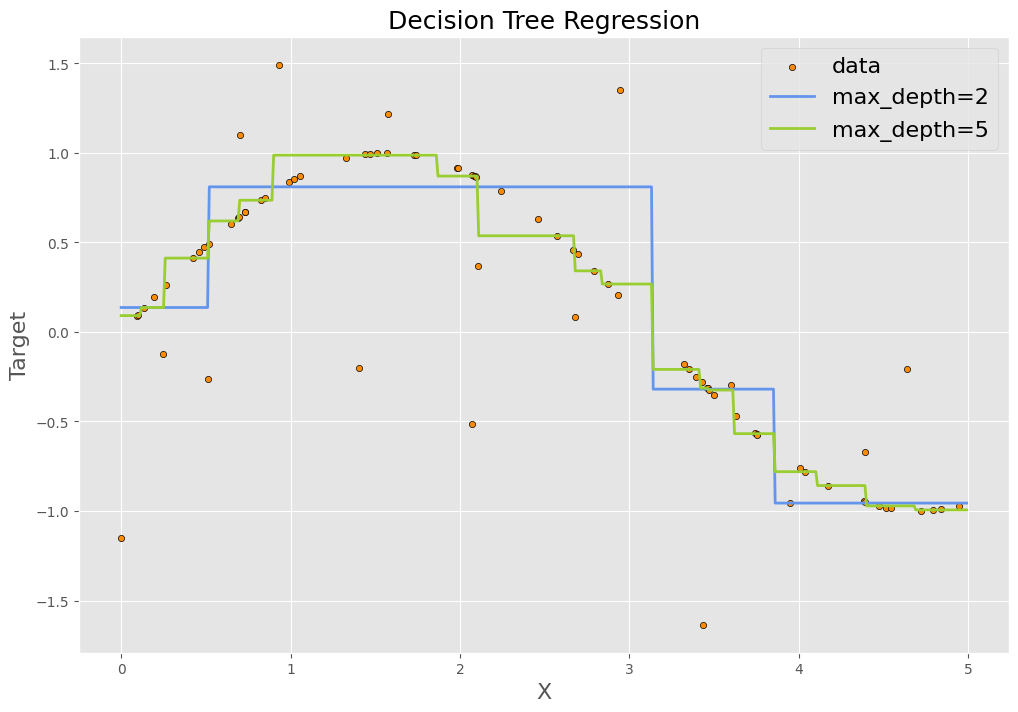

In [ ]:
# Predict
x_ = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = tree_reg_1.predict(x_)
y_2 = tree_reg_2.predict(x_)

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(x_, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(x_, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("X", fontsize=16)
plt.ylabel("Target", fontsize=16)
plt.title("Decision Tree Regression", fontsize=18)
plt.legend(fontsize=16)
plt.show()

## Árboles aleatorios

Incluso con todos los valores de los hiperparámetros fijados, el árbol resultante no está definido de forma determinista. Es decir que dos corridas seguidas pueden producir árboles (ligeramente) diferentes. Esto es parecido a lo que pasaba con el **perceptrón** al comenzar desde valores de los pesos diferentes.

Pero acá el origen de la diferencia es otra. En cada división se realiza una barajada aleatoria de las características. Si hay dos divisiones que producen la misma reducción de impureza, se utilizará la primera y este orden relativo podría cambiar entre las ejecuciones. Por lo tanto, es posible que queramos establecer el `random_state` para obtener resultados reproducibles.

También podemos aleatorizar el resultado de nuestro árbol adrede. Esto será útil más adelante cuando consideremos conjuntos de árboles (en Random Forests). Los parámetros para aleatorizar el árbol resultante son

* `splitter`: Para cada característica, el algoritmo encuentra la mejor división y calcula su importancia (la reducción de impurezas), dada por el parámetro `criterion` (que puede ser `gini` o `entropy`). Si `splitter` se elije como `best`, se elige el mejor corte de la mejor característica. Si `splitter='random'`, se eligen cortes al azar para cada característica y se utiliza el mejor entre ellos.

* `max_features`: En cada división, se considera sólo un subconjunto aleatorio de características `max_features`. Las opciones son:

  * un int. Se consideran `max_features` características en cada división.
  * un float. `max_features` es una fracción y se consideran max(1, int(max_features * n_features_in_)) en cada división.
  * "auto". `max_features=sqrt(n_features)`.
  * "sqrt". `max_features=sqrt(n_features)`.
  * "log2". `max_features=log2(n_features)`.
  * "None". entonces `max_features=n_features`.

Probemos esto con un dataset que van a usar para el ejercicio de la semana.

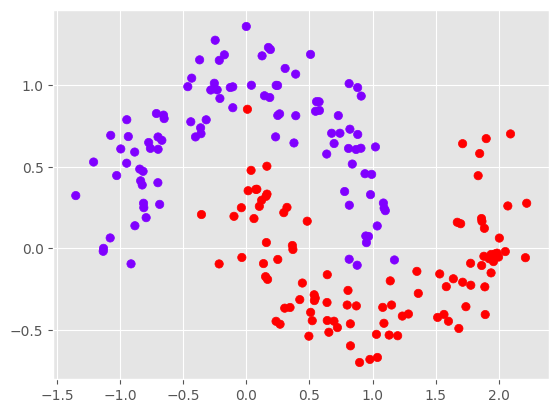

In [ ]:
from sklearn.datasets import make_moons
X, t = make_moons(n_samples=200, noise=0.15, random_state=42)

plt.scatter(X[:,0], X[:,1], c=t+5, cmap='rainbow')

In [ ]:
tree_clf_luna = DecisionTreeClassifier(max_depth=5, min_samples_leaf=3)


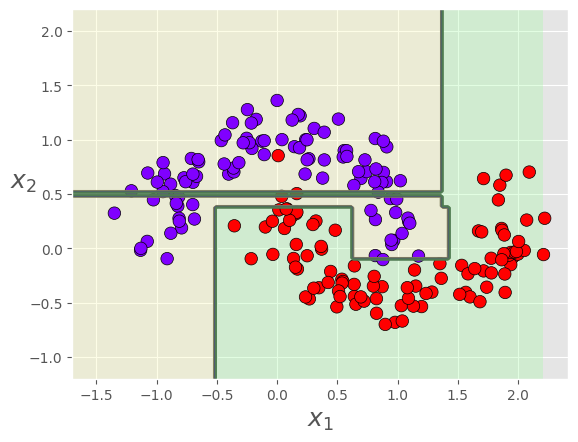

In [ ]:

tree_clf_luna.fit(X, t)
plot_decision_boundary(tree_clf_luna, X, t,
                        is_iris=False, axes=[-1.7, 2.2, -1.2, 2.2])

### Paréntesis repaso evaluación

In [ ]:
## Evaluación correcta!

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_clf_luna, X, t, cv=5, scoring='accuracy')

In [ ]:
scores

array([1.   , 0.95 , 0.95 , 0.975, 0.925])

In [ ]:
print(scores.mean())
print(scores.std())

0.96
0.025495097567963917


In [ ]:
## ¡LO QUE NO HAY QUE HACER!
from sklearn.metrics import accuracy_score

pred = tree_clf_luna.predict(X)
accuracy_score(t, pred)

0.99

### Volvemos a los árboles aleatorios

In [ ]:
tree_clf_random = DecisionTreeClassifier(max_depth=5, splitter='best', max_features=1)

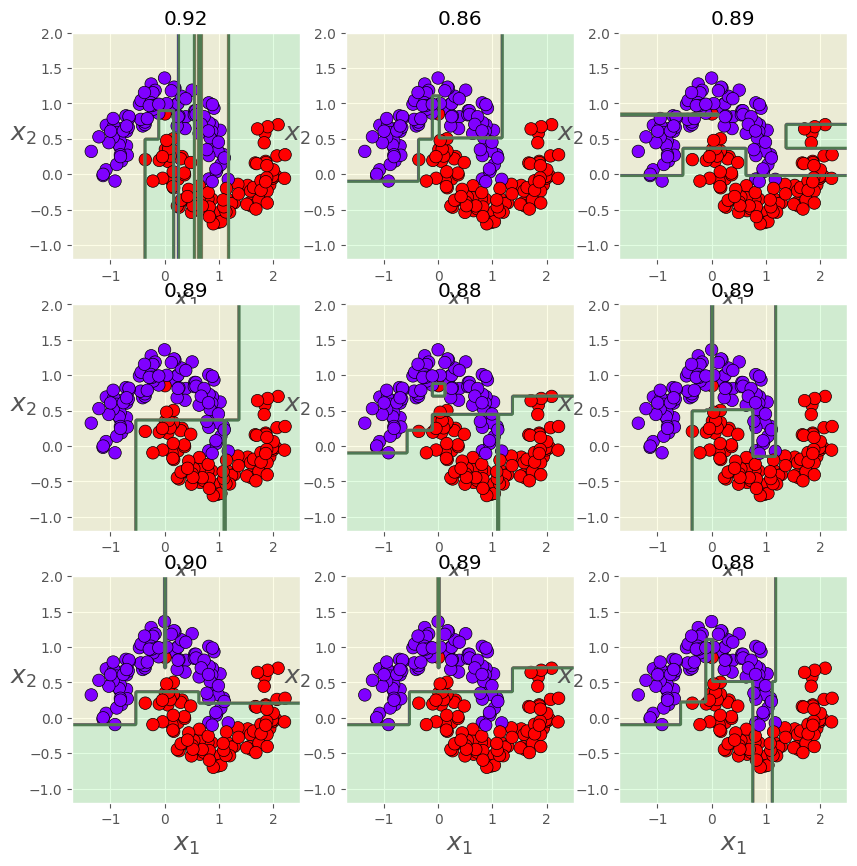

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    tree_clf_random.fit(X, t)
    ax = fig.add_subplot(3, 3, i+1)
    plot_decision_boundary(tree_clf_random, X, t,
                           is_iris=False, axes=[-1.7, 2.5, -1.2, 2.], ax=ax, legend=False)
    score_medio = cross_val_score(tree_clf_random, X, t, cv=5, scoring='accuracy').mean()
    ax.set_title('{:.2f}'.format(score_medio))

### Extra aleatorios

In [ ]:
tree_clf_extrarandom = DecisionTreeClassifier(max_depth=5, splitter='random', max_features=1)


DecisionTreeClassifier(max_depth=5, max_features=1, splitter='random')

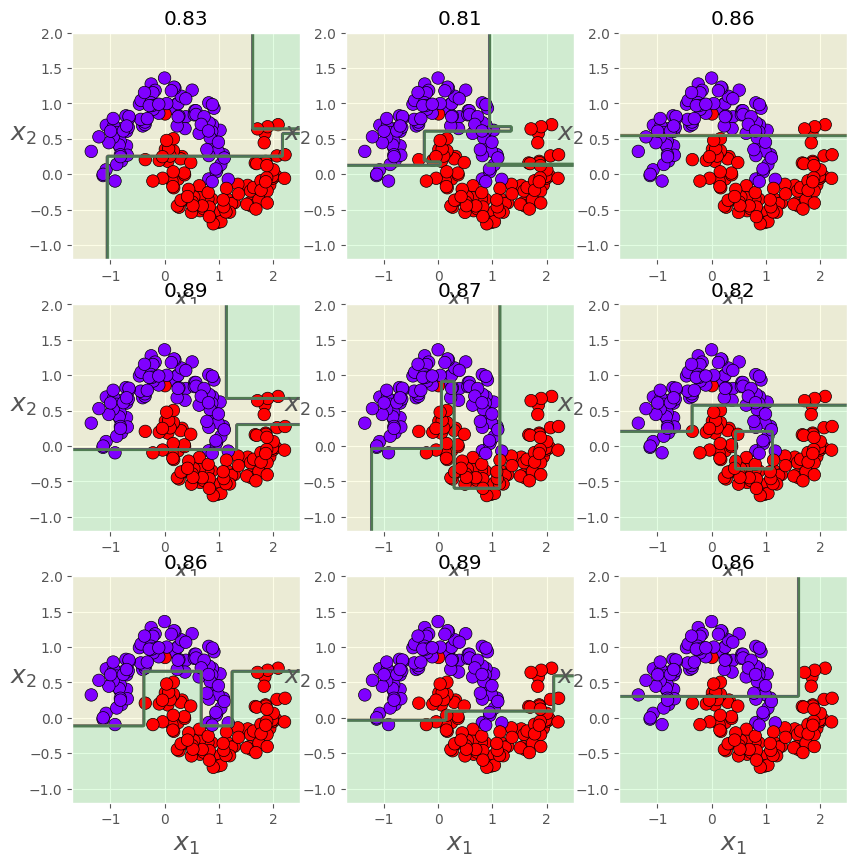

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    tree_clf_extrarandom.fit(X, t)
    ax = fig.add_subplot(3, 3, i+1)
    plot_decision_boundary(tree_clf_extrarandom, X, t,
                           is_iris=False, axes=[-1.7, 2.5, -1.2, 2.], ax=ax, legend=False)
    score_medio = cross_val_score(tree_clf_extrarandom, X, t, cv=5, scoring='accuracy').mean()
    ax.set_title('{:.2f}'.format(score_medio))

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier


In [ ]:
etc = ExtraTreesClassifier(n_estimators=100, max_depth=7, max_features=1)

In [ ]:
etc.fit(X, t)

ExtraTreesClassifier(max_depth=7, max_features=1)

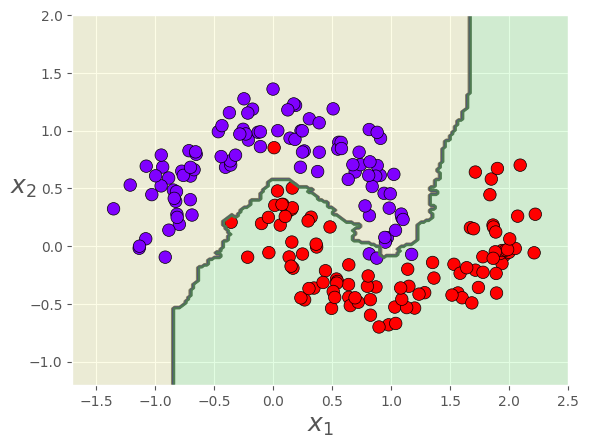

In [ ]:
plot_decision_boundary(etc, X, t,
                        is_iris=False, axes=[-1.7, 2.5, -1.2, 2.], legend=False)

In [ ]:
scores_rf = cross_val_score(etc, X, t, cv=5, scoring='accuracy')

In [ ]:
print(scores_rf.mean())

0.97
